In [71]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import itertools
from scipy.ndimage import median_filter

## Input of PIV results and aggregate images

In [72]:
# # open .h5 file containing piv results.
# h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/piv_cut1/frame_1_to_375/"
# with h5py.File(h5_file_path, "r") as h5f:
#     U = h5f["U"][:] # shape: frame, rows, columns 
#     V = h5f["V"][:]
#     M = h5f["M"][:]
#     xgrid = h5f["xgrid"][:]
#     ygrid = h5f["ygrid"][:]

In [73]:
# Alternative: Open .h5 file containing piv results. (if files were stored saperatly)
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/piv_cut1(2)/subregion_all_frame/"
with h5py.File(h5_file_path+"U_matrix", "r") as h5f:
    U = h5f["matrix"][:] # shape: frame, rows, columns 

with h5py.File(h5_file_path+"V_matrix", "r") as h5f:
    V = h5f["matrix"][:]

with h5py.File(h5_file_path+"M_matrix", "r") as h5f:
    M = h5f["matrix"][:]

with h5py.File(h5_file_path+"xgrid_matrix", "r") as h5f:
    xgrid = h5f["matrix"][:]

with h5py.File(h5_file_path+"ygrid_matrix", "r") as h5f:
    ygrid = h5f["matrix"][:]

In [74]:
# open .h5 file for aggregate images and original red beads images
aggregate_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1(2).h5"
with h5py.File(aggregate_file_path, "r") as h5f:
    aggregate = h5f["green"][:]
    red_beads = h5f["red"][:]

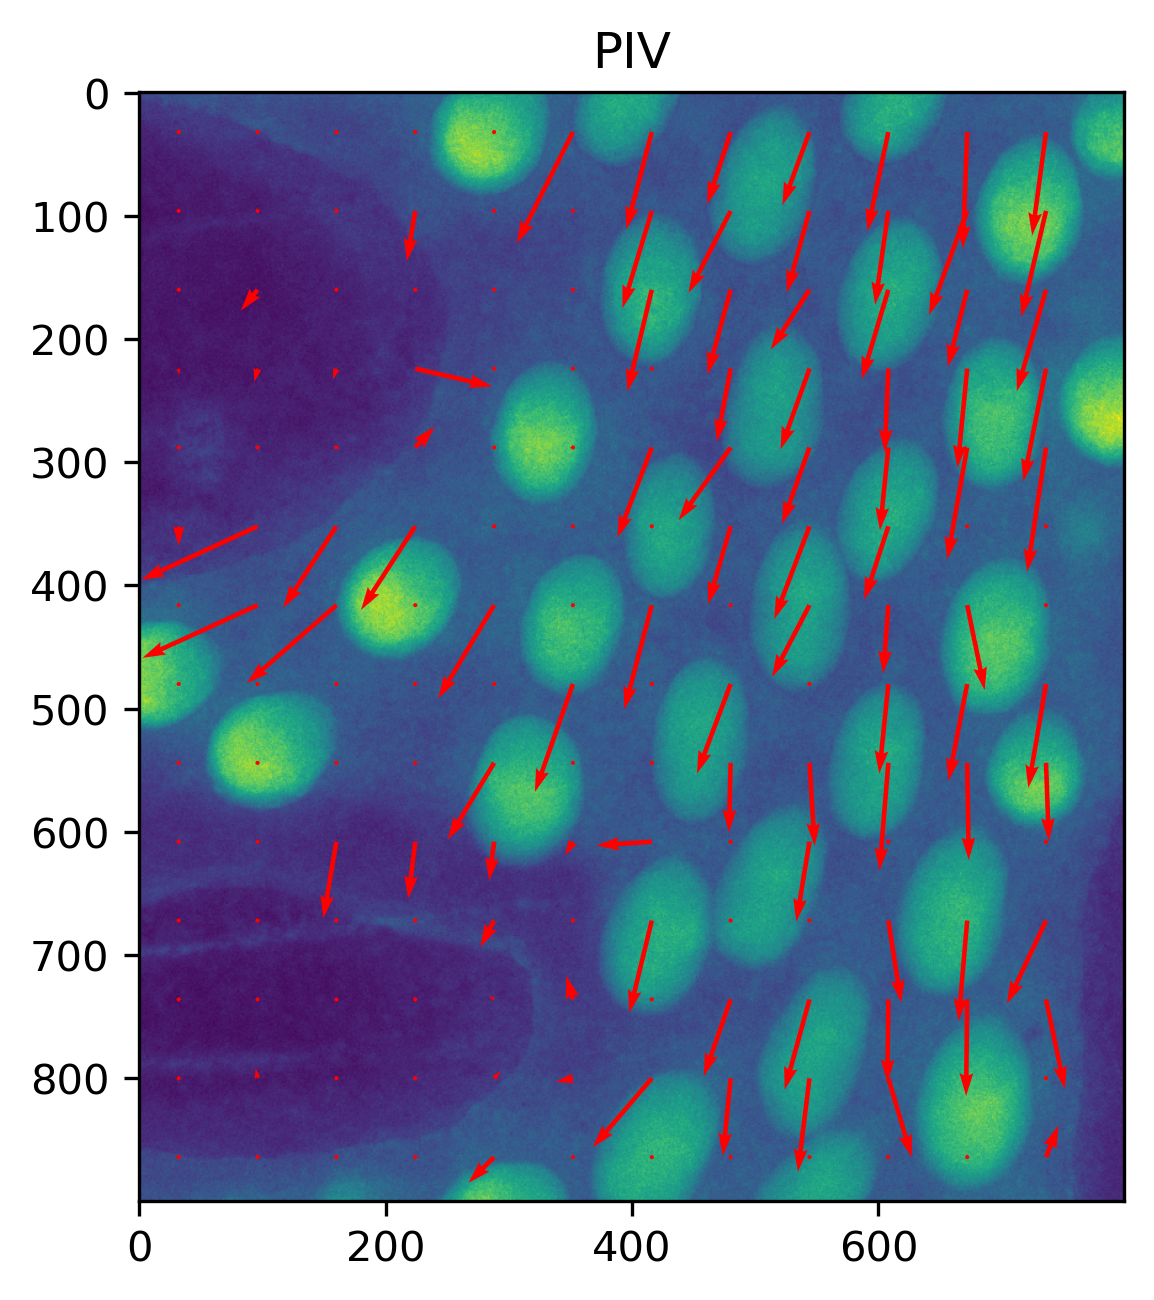

In [75]:
# Visualise the PIV results for a certain time point. 
t = 110

plt.figure(dpi=300)

plt.title("PIV")
plt.imshow(aggregate[300])
plt.quiver(ygrid[t], xgrid[t], U[t], -V[t], color = "red")
# # Highlight the reference polarisation vector (manually determined).
# plt.quiver([280], [950], [3], [28], color="white") # center in x, y coordinate!
# plt.quiver([480], [1100], [7], [10], color="white")
plt.show()

## Extract one single aggregate and average the direction arrows surrounding it

In [76]:
def select_neighbour_region(center, t, dist, xgrid, ygrid, U, V):
    ## Function select the vectors in the surrondings of given center [x0, y0]. 
    # center: [y, x] coordinates of aggregate center. 
    # t: frame number.
    # dist: the radius of square region surrounds the center. Define the neighbour region size. 
    
    # Find out the arrows in the surrounding of the center of aggregate
    # Define the region of surrounding and found the coordinates inside the surrounding area.
    neighbour_region = [[i for i in range(center[0]-dist, center[0]+dist)],
                       [i for i in range(center[1]-dist, center[1]+dist)]]
    neighbour_xgrid = np.unique(xgrid[0][np.isin(xgrid[0], neighbour_region[0])])
    neighbour_ygrid = np.unique(ygrid[0][np.isin(ygrid[0], neighbour_region[1])])
    # The grid (as combination of coordinate pairs with x and y pixel coordinates) of considered vectors. 
    grid_combi = [list(comb) for comb in itertools.product(neighbour_xgrid, neighbour_ygrid)]
    final_select_xgrid = [comb[0] for comb in grid_combi] # x component of the pairwise combination. 
    final_select_ygrid = [comb[1] for comb in grid_combi] # y component of the pairwise combination. 
    
    # Determine the indices of the grids in order to find the corresponding U and V elements.
    row_indices = [np.where(xgrid[0][:, 0] == number)[0][0] for number in final_select_xgrid]
    col_indices = [np.where(ygrid[0][0, :] == number)[0][0] for number in final_select_ygrid]
    vec_indeces = [[x, y] for x, y in zip(row_indices, col_indices)]
    # Pick out the vector directions from U and V based on the vec_indices list. 
    select_U = [U[t][row, col] for row, col in vec_indeces]
    select_V = [V[t][row, col] for row, col in vec_indeces]

    return np.array(final_select_xgrid), np.array(final_select_ygrid), np.array(select_U), np.array(select_V)

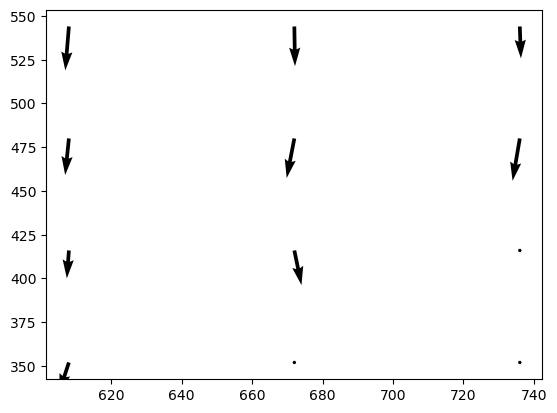

In [77]:
# center = [y, x] corrdinate!
x, y, u, v = select_neighbour_region([450, 690], 110, 100, xgrid, ygrid, U, V)
plt.quiver(y, x, u, -v)

In [78]:
def avrage_neighbour_direction_over_time(center, t0, t1, dist, xgrid, ygrid, U, V):
    # Calculate the average of vectors over the time t0 to t1 within the neighbour region. 
    # center: [y, x] coordinates. 
    # t0, t1: the start and end frame.
    # dist: the radius for squared surrounding region. Define the size of surrounding region. 

    avg_vec_u = [] 
    avg_vec_v = []

    for t in range(t0, t1): 
        # Get the vectors from surrounding region. 
        x, y, u, v = select_neighbour_region(center, t, dist, xgrid, ygrid, U, V)
        # Calculate the mean over surrounding vectors.
        avg_vec_u.append(np.mean(u))
        avg_vec_v.append(np.mean(v))

    return np.array(avg_vec_u), np.array(avg_vec_v) 

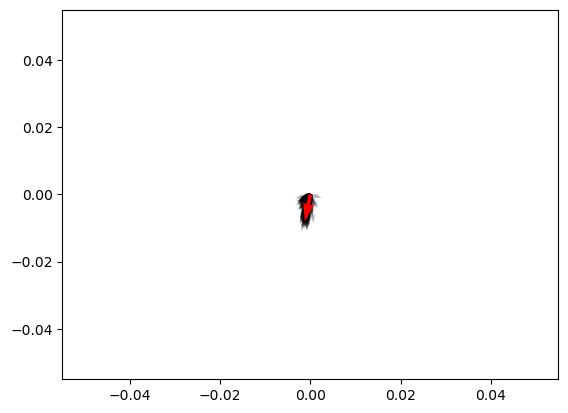

In [79]:
t0 = 0
t1 = np.shape(U)[0]
avg_u, avg_v = avrage_neighbour_direction_over_time([450, 690], t0, t1, 100, xgrid, ygrid, U, V)

# Visualisation with all average vectors satart from (0,0).
origin = np.zeros(t1-t0)
# x components: avg_u, y components: -avg_v
plt.quiver(origin, origin, avg_u, -avg_v, alpha = 0.3)
# Highlight the reference polarisation vector with red color. 
plt.quiver([0], [0], [-16], [-80], color="red") 

In [80]:
def rose_plot(center, x, y, dist, reference_length):
    # Having vectors in x and y components. Convert into angles. 
    # Hitogram counting the number of vectors with corresponding angle. -- for all frames contained in PIV matrix.  
    # center: [y, x] pixel coordinates for manually defined aggregate center. 
    # x, y: the rection components of the reference polarisation vector. 
    # dist: radius of squared surounding region. 
    # reference_length: For visualisation of reference polarisation vector direction. Manually determine the length. 
    
    t0 = 0
    t1 = np.shape(U)[0]
    # Calculate the averaged surounding flow vectors for all frames contained in PIV matrix U. 
    avg_u, avg_v = avrage_neighbour_direction_over_time(center, t0, t1, dist, xgrid, ygrid, U, V)
    # Calculate angles for each of the averaged flow vector. 
    angles = np.arctan2(-avg_v, avg_u)
    
    # Extra refrence polarisation vecotor for highlighting. 
    extra_angle = np.arctan2(y, x)
    
    # Plot in a rose plot. Histogramm counting the number of vectors with certain angle. 
    plt.figure(figsize=(6, 6), dpi=300)
    ax = plt.subplot(111, projection='polar')
    num_bins = 50
    ax.hist(angles, bins=num_bins, color='c', edgecolor='black') # The number of vectors with certain angle.
    ax.plot([extra_angle, extra_angle], [0, reference_length], color='red', linewidth=2, label='Highlighted Vector', alpha=0.5)
    plt.show()

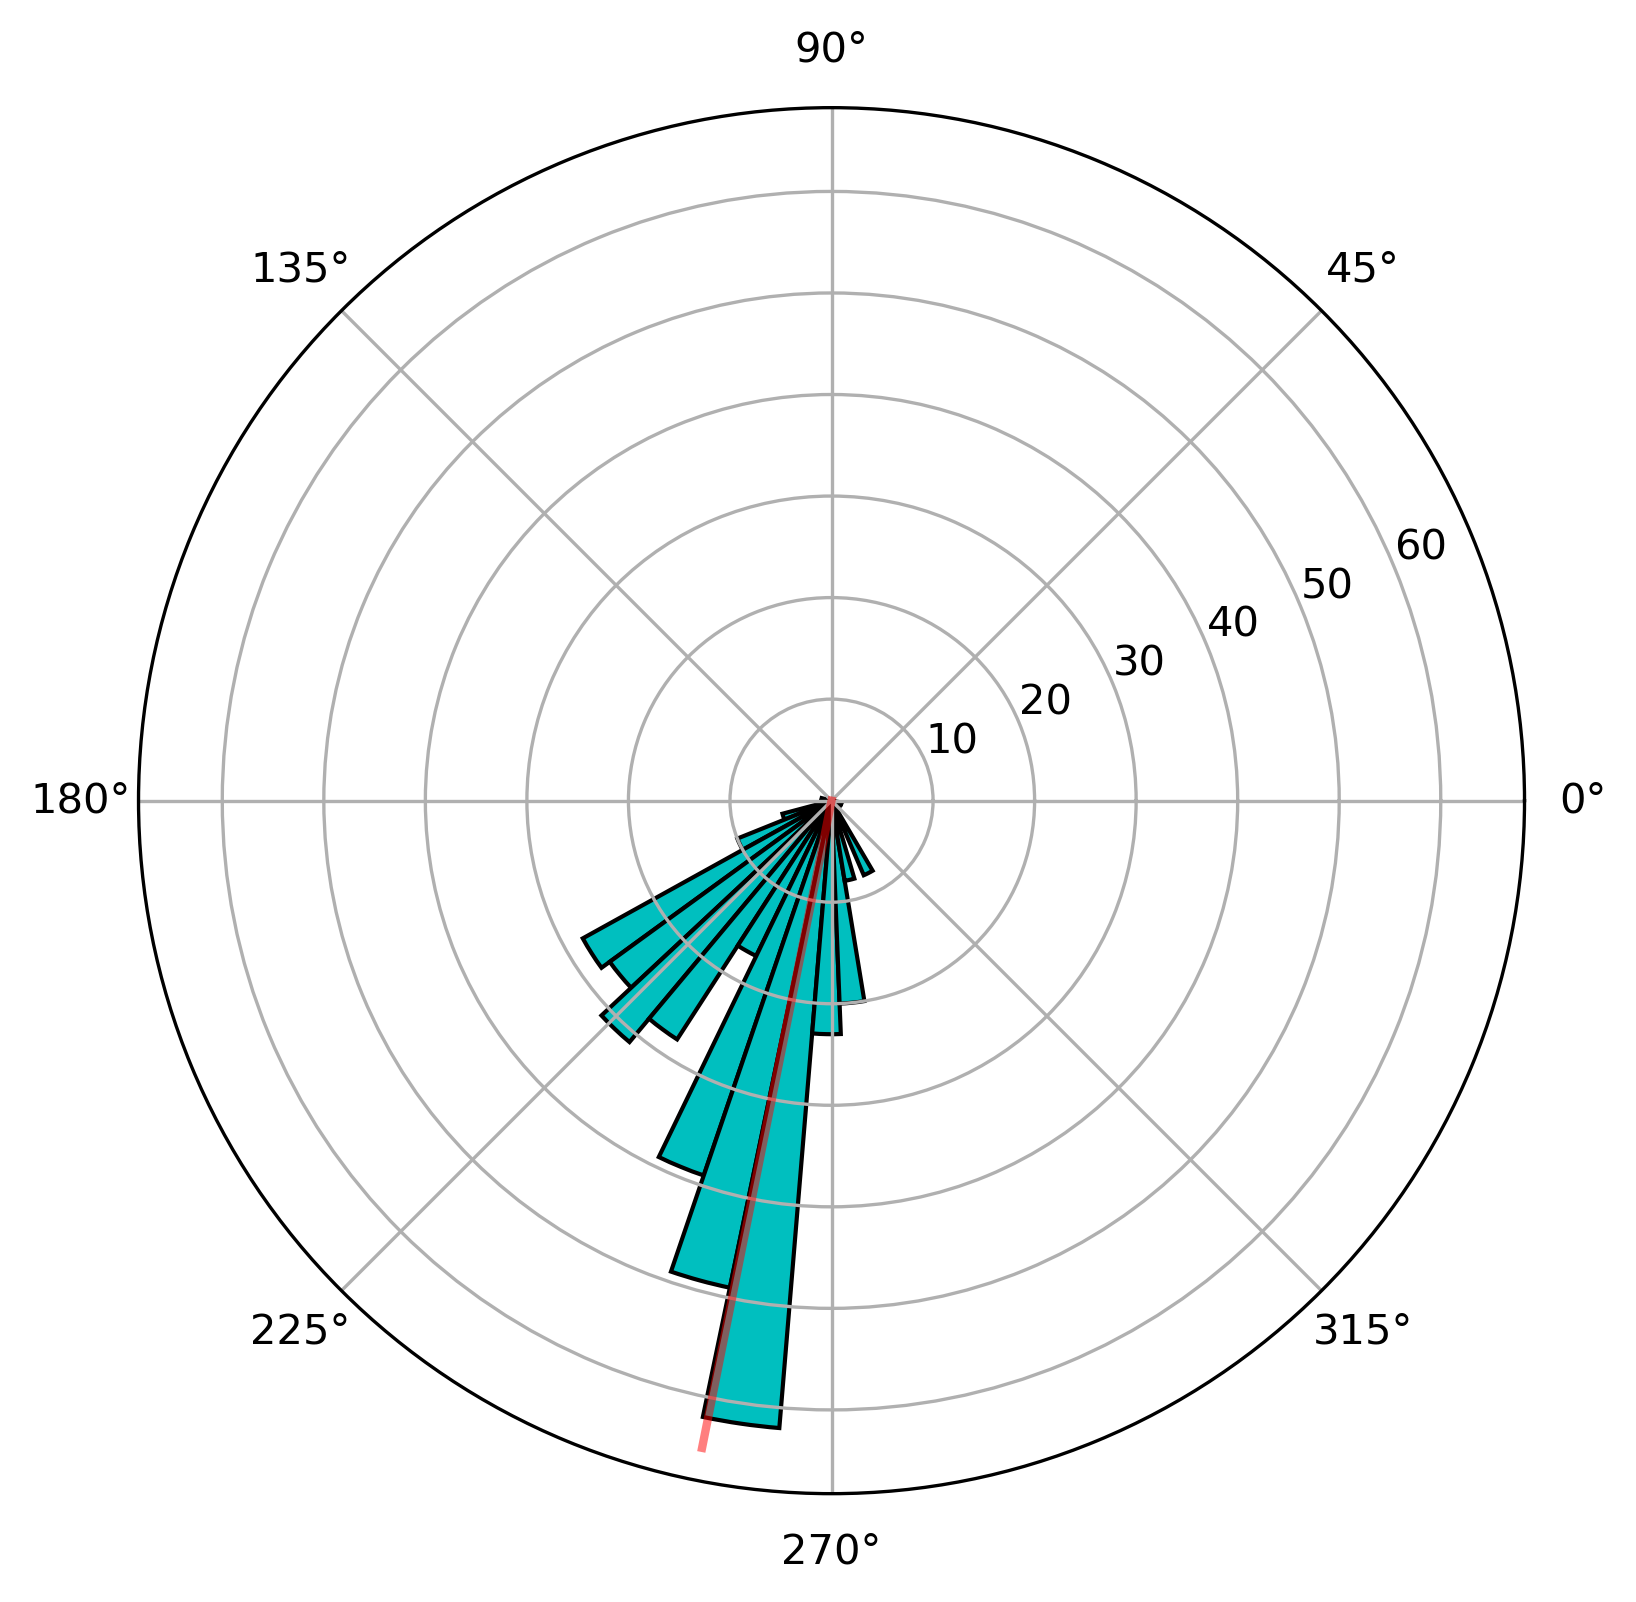

In [81]:
rose_plot([450, 690], -16, -80, 100, 65)

In [82]:
def dot_product_polarisation_to_avg_vectors(avg_u, avg_v, polar_u, polar_v):
    # Having multiple average vectors from neighbour regions, calculate the dot product between average vectors and polarization vectors.
    # avg_u, -avg_v: the x and y components of average flow vectors. The values are in order of frame number/time.
    # polar_u, polar_v: the x and y components of reference vector. 

    # Normalization of average flow vectors.
    magnitude_flow_vector = np.sqrt(avg_u**2 + avg_v**2)
    magnitude_flow_vector[magnitude_flow_vector==0] = 1e-10 # Prevent division by zero.
    avg_u_normalized = avg_u / magnitude_flow_vector
    avg_v_normalized = avg_v / magnitude_flow_vector

    # Normalization of reference vector. 
    magnitude_ref_vector = np.sqrt(polar_u**2 + polar_v**2) # Known the reference vector has non-zero magnitude.
    polar_u_normalized = polar_u / magnitude_ref_vector
    polar_v_normalized = polar_v / magnitude_ref_vector

    # Calculation of dot product. Apply term: dot_product = x_ref * x + y_ref * y.
    dot_products = polar_u_normalized * avg_u_normalized + polar_v_normalized * avg_v_normalized

    return dot_products

In [83]:
def angle_velocity_plot(center, x, y):
    # center: [y, x] coordinates of the aggregate center. 
    # x: x direction component of the reference vector.
    # y: y direction component of the reference vector. 
    
    t0 = 0
    t1 = np.shape(U)[0]

    # Average flow vector from neighbour region. 
    avg_u, avg_v = avrage_neighbour_direction_over_time(center, t0, t1, 100, xgrid, ygrid, U, V)
    # Dot product between avgerage flow vector and reference vector. (in frame order)
    angle_all_frame = dot_product_polarisation_to_avg_vectors(avg_u, -avg_v, x, y)
    
    fig, ax = plt.subplots(1,1, facecolor=(1, 1, 1), dpi=300, figsize=(5, 2))
    # Plot with two y-axis.
    twin_stacked = ax.twinx()
    # Plot for dot product.
    p1 = ax.plot(angle_all_frame, alpha=0.3, zorder=0)
    # Add median filter for smoothing. 
    p2 = ax.plot(median_filter(angle_all_frame, size=30, mode="nearest"), c="blue", zorder=1)
    ax.set_ylabel('dot product')
    # Plot for velocity. 
    velocity = np.sqrt(avg_u**2 + avg_v**2)
    twin1 = twin_stacked.scatter(np.array([i for i in range(len(avg_u))]), velocity, alpha=0.2, c="orange", zorder=2)
    # Apply median filter for smoothing.
    twin2 = twin_stacked.plot(median_filter(velocity, size=30, mode="nearest"), c="orange", zorder=3)
    twin_stacked.set_ylabel('velocity')

    # Add line to highlight the maximum velocity (based on median filtered).
    maxi_velocity_frame = np.argmax(median_filter(velocity, size=30, mode="nearest"))
    ax.axvline(x = maxi_velocity_frame, color="red")
    
    ax.set_xlabel("frame")
    plt.show()
    
    return maxi_velocity_frame

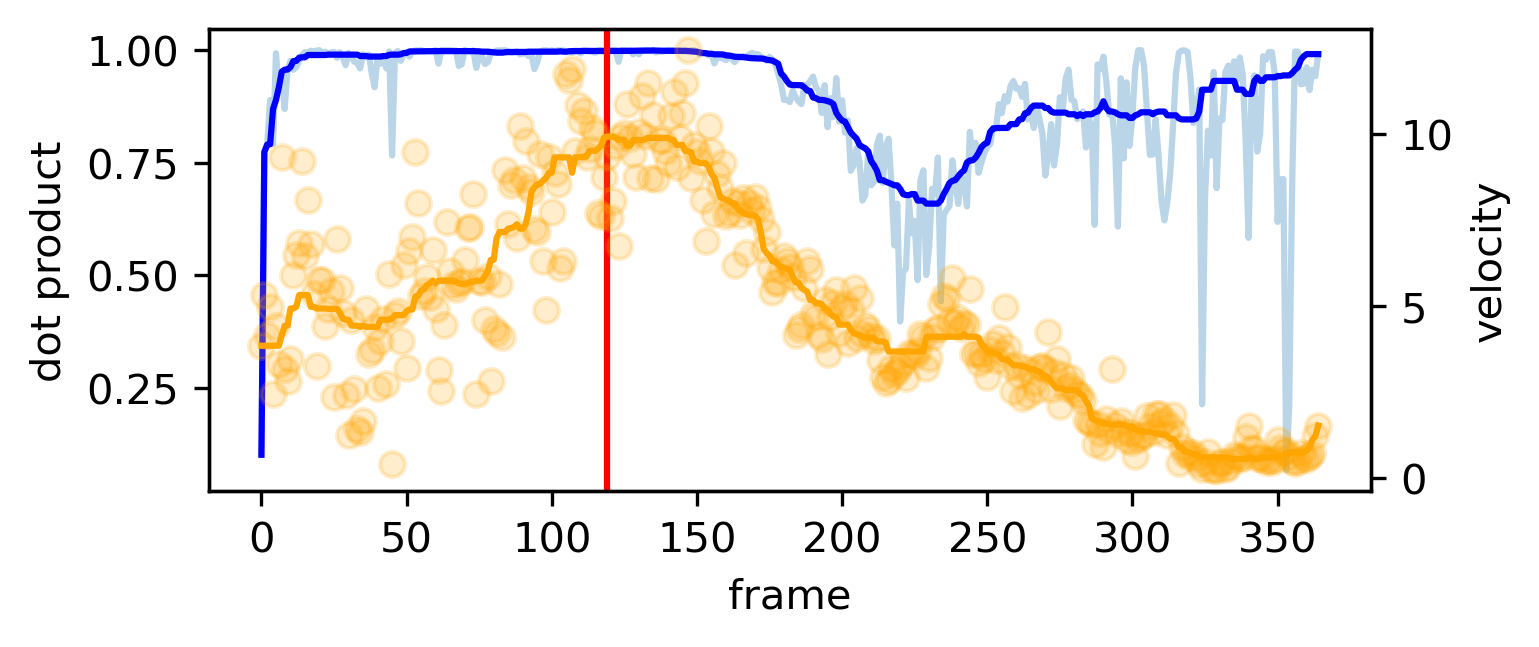

119

In [84]:
angle_velocity_plot([450, 690], -16, -80)

In [85]:
# # Alternative 1: Use index from grid matrix, check if the correspoding position has in red beads mask value NaN.
# # If the value is NaN, then find out the index of this position in grid matrices. 
# # Then set the vector values with this index to NaN. 

# xgrid_matrix = xgrid[0]
# ygrid_matrix = ygrid[0]
# red_bead_mask = sub_frame[0]
# U_matrix = U[0]
# V_matrix = V[0]

# # Find out the index for position from grid matrix which corresponds to NaN in masks. 
# for i in range(xgrid_matrix.shape[0]):
#     mask_value = red_bead_mask[xgrid_matrix[i,:].astype(int), ygrid_matrix[i,:].astype(int)]
#     is_nan = np.isnan(mask_value)
#     col_index = np.where(is_nan)[0]
#     row_index = np.full(len(col_index), i)

#     # Change the vector value with those index to NaN. 
#     U_matrix[row_index, col_index] = np.nan
#     V_matrix[row_index, col_index] = np.nan

# # Plot the cutted vector field.
# plt.quiver(ygrid_matrix, xgrid_matrix, U_matrix, V_matrix)
# plt.gca().invert_yaxis()

In [86]:
# # Write the above processing as function.
# def piv_mask(t, xgrid_set, ygrid_set, red_bead_set, U, V): 
    
#     xgrid_matrix = xgrid[t]
#     ygrid_matrix = ygrid[t]
#     red_bead_mask = red_bead_set[t]
#     U_matrix = U[t]
#     V_matrix = V[t]
    
#     # Find out the index for position from grid matrix which corresponds to NaN in masks. 
#     for i in range(xgrid_matrix.shape[0]):
#         mask_value = red_bead_mask[xgrid_matrix[i,:].astype(int), ygrid_matrix[i,:].astype(int)]
#         is_nan = np.isnan(mask_value)
#         col_index = np.where(is_nan)[0]
#         row_index = np.full(len(col_index), i)
    
#         # Change the vector value with those index to NaN. 
#         U_matrix[row_index, col_index] = np.nan
#         V_matrix[row_index, col_index] = np.nan
        
#     return ygrid_matrix, xgrid_matrix, U_matrix, V_matrix

In [87]:
# ygrid_matrix, xgrid_matrix, U_matrix, V_matrix = piv_mask(0, xgrid, ygrid, sub_frame, U, V)

# t = 0

# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title("Red Beads Background")
# plt.imshow(sub_frame[t], cmap= ListedColormap(["white", "red"]))

# plt.subplot(1, 2, 2)
# plt.title("Only PIV")
# plt.quiver(ygrid_matrix, xgrid_matrix, U_matrix, V_matrix)
# plt.gca().invert_yaxis()
# plt.show()

In [88]:
# Alternative 2: Get all index of NaN in mask. Find if the index appears in grid matrix.
# If appears, find out the position in grid matrices.
# Set the vector values with those positions to NaN. 

# xgrid_matrix = xgrid[0]
# ygrid_matrix = ygrid[0]
# red_bead_mask = sub_frame[0]
# U_matrix = U[0]
# V_matrix = V[0]

# # Find out the positions of NaN in red bead mask 


In [89]:
# def rose_plot(center, x, y):
#     # Having vectors in x and y components. Convert into angles and magnitudes.
    
#     avg_u, avg_v = avrage_neighbour_direction_over_time(center, t0, t1, 100, xgrid, ygrid, U, V)
    
#     angles = np.arctan2(-avg_v, avg_u)
    
#     # Extra vecotor for highlighting. 
#     extra_angle = np.arctan2(y, x) # np.arctan2(y, x)
#     #extra_magnitude = np.sqrt(x**2 + y**2)
    
#     # Plot in a rose plot. Histogramm counting the number of vectors with certain angle. 
#     plt.figure(figsize=(6, 6))
#     ax = plt.subplot(111, projection='polar')
#     num_bins = 50
#     ax.hist(angles, bins=num_bins, color='c', edgecolor='black') # The number of vectors with certain angle.
#     ax.plot([extra_angle, extra_angle], [0, 40], color='red', linewidth=2, label='Highlighted Vector', alpha=0.5)
#     #ax.set_title('Rose Plot from Vector Components')
#     #plt.savefig("subregion_cut1_direction_all_frame(h2)", dpi=300)
#     plt.show()